# QJE Cleaning
This notebook walks through how the QJE articles were sorted into categories of articles and non-articles.

## Load Libraries

In [3]:
from tokenize import Ignore
from numpy import NaN
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
import multiprocessing as mp
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import matplotlib.pyplot as plt    

## Load Files
Please change file paths to local and comment out file reads that are not present eg: datadump

In [4]:
masters = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Master lists\\QJE_master.xlsx")
pivots = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\pivots\\QJE_pivots.xlsx")
scopus = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Scopus\\QJE_SCOPUS.xlsx")
datadump = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_datadump.xlsx")

pd.set_option('display.max_colwidth', None)

## Create file names
For output

In [3]:
authors="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_authors.xlsx"
non_auth="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_Nauthors.xlsx"
saveas="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_processed.xlsx"
reviews="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_reviews.xlsx"
misc="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_misc.xlsx"
conf="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_conf.xlsx"

## Some random checks on the masters list
My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [142]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

,title
front matter,412
back matter,409
volume information,178
recent publications,141
books received,100
recent publications upon economics,86
[notes and memoranda],39
the quarterly journal of economics,14
chapters on machinery and labor,4
[introduction],4


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [143]:
temp1=masters[masters['authors'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1)

,title
front matter,412
back matter,409
volume information,178
recent publications,141
books received,100
recent publications upon economics,86
[notes and memoranda],36
the quarterly journal of economics,14
scientific publications of harvard university,3
[introduction],3


In [144]:
# block for testing regex patterns
#pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters['title'].str.lower().str.match(r'(^|: )report of the')]
#masters[masters['title'].str.lower().str.match(r'(^|.*: )report of the')]
#masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'

,Unnamed: 0,stable_url,authors,title,abstract,content_type,issue_url,pages
5996,5996,https://www.jstor.org/stable/1882418,A. Piatt Andrew,Report of the Mexican Currency Commission,NaN,NaN,https://www.jstor.org/stable/10.2307/i305257,585-587
6424,6424,https://www.jstor.org/stable/1882286,Edward Cummings,Report of the Connecticut Labor Bureau,NaN,NaN,https://www.jstor.org/stable/10.2307/i305223,480-487


It seems anything with duplicates greater than 5 are miscellaneous according to the list above and the bulk of miscellaneous content can be removed.

In [146]:
temp2=masters[(masters['content_type'].isna()==True) & (masters['authors'].isna()==True)]['title'].str.lower().value_counts()
pd.DataFrame(temp2)
removal=list(temp2[temp2>=5].index)
removal
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

In [147]:
masters.loc[masters['title'].str.lower().str.match(r'\[introduction\]')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'schumpeter prize$')==True,'content_type']='MISC'

In [148]:

scopus.rename(columns = {'abstract':'abstract2', 'title':'title2', 'authors':'authors2'}, inplace = True)
scopus['pages2']=scopus['pages']
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN  


## Classifying other content

In [149]:
sum(masters.content_type.isna())
#masters.shape[0]

5313

In [150]:
masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.authors.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters[(masters['content_type']=='Review2') | (masters['content_type']=='Review')].shape[0] #reviews

113

In [151]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?).*comment.*$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*comment$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(a further|further) comment.*$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0]
#.shape[0] 
#comments

,Unnamed: 0,stable_url,authors,title,abstract,content_type,issue_url,pages
157,157,https://www.jstor.org/stable/26372539,Gary Lyn and Andrés Rodríguez-Clare,EXTERNAL ECONOMIES AND INTERNATIONAL TRADE REDUX: COMMENT,NaN,Comment,https://www.jstor.org/stable/10.2307/e26372527,1895-1905
448,448,https://www.jstor.org/stable/25098902,Christopher L. Foote and Christopher F. Goetz,The Impact of Legalized Abortion on Crime: Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i25098891,407-423
839,839,https://www.jstor.org/stable/2587007,"Steven M. Fazzari, R. Glenn Hubbard and Bruce C. Petersen",Investment-Cash Flow Sensitivities are Useful: A Comment on Kaplan and Zingales,NaN,Comment,https://www.jstor.org/stable/10.2307/i324120,695-705
953,953,https://www.jstor.org/stable/2586993,"Kevin Lee, M. Hashem Pesaran and Ron Smith",Growth Empirics: A Panel Data Approach -- A Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i324111,319-323
1195,1195,https://www.jstor.org/stable/2118344,Kyoji Fukao and Roland Benabou,History Versus Expectations: A Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i337095,535-542
1406,1406,https://www.jstor.org/stable/2937827,David M. Newbery,The Isolation Paradox and the Discount Rate for Benefit-Cost Analysis: A Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i352301,235-238
1486,1486,https://www.jstor.org/stable/1885547,"Wilfrid W. Csaplar, Jr. and Edward Tower",Trade and Industrial Policy Under Oligopoly: Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i332453,599-602
1567,1567,https://www.jstor.org/stable/1885073,Daniel J. Seidmann,Incentives for Information Production and Disclosure: Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i332429,445-452
1606,1606,https://www.jstor.org/stable/1885700,Robert E. Kohn,The Limitations of Pigouvian Taxes as a Long-Run Remedy for Externalities: Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i332475,625-630
1704,1704,https://www.jstor.org/stable/1885748,Robert Cameron Mitchell and Richard T. Carson,Option Value: Empirical Evidence From a Case Study of Recreation and Water Quality: Comment,NaN,Comment,https://www.jstor.org/stable/10.2307/i332473,291-294


In [152]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

156

In [153]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?|).*rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

,Unnamed: 0,stable_url,authors,title,abstract,content_type,issue_url,pages
2524,2524,https://www.jstor.org/stable/1882050,Assar Lindbeck,Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i305245,665-683
2527,2527,https://www.jstor.org/stable/1882053,Orley Ashenfelter and John H. Pencavel,"American Trade Union Growth, 1900-1960: A Rejoinder",NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i305245,691-692
2542,2542,https://www.jstor.org/stable/1880808,Paul A. Samuelson,[The Consumer does Benefit from Feasible Price Stability]: Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i332309,500-503
2562,2562,https://www.jstor.org/stable/1880572,Peter L. Swan,The Influence of Monopoly on Product Innovation: Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i332308,346-349
2591,2591,https://www.jstor.org/stable/1882275,J. C. H. Fei,[The Marginalist Principle in a Discrete Production Model Under Uncertain Demand]: Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i305244,710-711
2593,2593,https://www.jstor.org/stable/1882277,William Poole,[Optimal Choice of Monetary Policy Instruments in a Simple Stochastic Macro Model]: Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i305244,716-717
2637,2637,https://www.jstor.org/stable/1881845,John F. Kain,"[A Note on John Kain's ""Housing Segregation, Negro Employment and Metropolitan Decentralization""]: Rejoinder",NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i305216,161-162
2689,2689,https://www.jstor.org/stable/1883018,James Tobin,[Comment on Tobin]: Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i332354,328-329
3002,3002,https://www.jstor.org/stable/1880629,Sayre P. Schatz,Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i332299,246-247
3611,3611,https://www.jstor.org/stable/1882154,Evsey D. Domar,Accelerated Depreciation: A Rejoinder,NaN,Rejoinder,https://www.jstor.org/stable/10.2307/i305239,299-304


In [154]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

4

In [155]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

4746

In [2]:
# code block for testing regex
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]
#masters[masters.content_type=='Discussion']

## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. The next block separates special issues (S) from normal issues (N) 

In [158]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

N    529
S      3
Name: type, dtype: int64

## Merging pivots and masters

In [159]:
result = pd.merge(masters, pivots[['issue_url','year','volume','issue','journal','type']], how="left", on=["issue_url", "issue_url"])

## Summaries

In [160]:
pd.DataFrame(result.content_type.value_counts())

,content_type
Article,4746
MISC,1383
Comment,263
Reply,156
Review,113
Rejoinder,31
Discussion,4


In [161]:
pd.DataFrame(result[result.year>1939].content_type.value_counts())

,content_type
Article,3162
MISC,824
Comment,249
Reply,133
Rejoinder,15
Review,3


In [162]:
pd.DataFrame(result[(result.year>1939) & (result.year<2011)].content_type.value_counts())

,content_type
Article,2914
MISC,778
Comment,248
Reply,132
Rejoinder,15
Review,3


In [163]:
result.to_excel(saveas, index=False)

## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus. matching up the Scopus data is useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is either corrected or discarded. 

The next section reads in the processed data previously saved. Please make sure the path in the variable 'cleaned' matches the file path on your local machine.

In [6]:
cleaned=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\processed\\QJE_processed.xlsx')
cleaned['volume']=cleaned['volume'].astype(int)
scopus['pages']=scopus['pages'].str.strip()
#print(scopus.shape)


In [12]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

2016

This is the number of entries on Scopus

In [78]:
#Note that we only have data up to 2016 in the masterlists because of the moving wall on JSTOR
print(sum(scopus['year']<=2016))
print(scopus.shape)

4299
(4453, 14)


In [81]:
x=cleaned[['year','issue','volume','pages']].value_counts().reset_index()
checks=pd.merge(cleaned, x, on=['year', 'issue','volume','pages'], how='left')
y=pd.merge(checks[(pd.isna(checks[0])==False) & (checks[0]<2)], scopus, on=['year', 'issue','volume','pages'], how='left')
temp=checks[checks[0]>=2].rename(columns={'authors':'authors_x','title':'title_x','abstract':'abstract_x','journal':'journal_x'})
Merged=pd.concat([y,temp]).reset_index(drop=True)

Check how many of the scopus entries matched.

In [52]:
sum(Merged['title_y'].isna()==False)
Merged

stable_url  \
0     https://www.jstor.org/stable/26372674   
1     https://www.jstor.org/stable/26372675   
2     https://www.jstor.org/stable/26372676   
3     https://www.jstor.org/stable/26372677   
4     https://www.jstor.org/stable/26372678   
...                                     ...   
5797   https://www.jstor.org/stable/1883631   
5798   https://www.jstor.org/stable/1883756   
5799   https://www.jstor.org/stable/1883757   
5800   https://www.jstor.org/stable/1881858   
5801   https://www.jstor.org/stable/1881859   

                                                                   authors_x  \
0                         SCOTT R. BAKER, NICHOLAS BLOOM and STEVEN J. DAVIS   
1           Sarah Baird, Joan Hamory Hicks, Michael Kremer and Edward Miguel   
2                       Amy Finkelstein, Matthew Gentzkow and Heidi Williams   
3                                            Morgan Kelly and Cormac Ó Gráda   
4     Pedro Bordalo, Katherine Coffman, Nicola Gennaioli and Andrei Shleifer   
...                                                                      ...   
5797                                                                     NaN   
5798                                                                     NaN   
5799                                                                     NaN   
5800                                                         Alfred Marshall   
5801                                                     Frederick B. Hawley   

                                                                              title_x  \
0                                               MEASURING ECONOMIC POLICY UNCERTAINTY   
1                        WORMS AT WORK: LONG-RUN IMPACTS OF A CHILD HEALTH INVESTMENT   
2     SOURCES OF GEOGRAPHIC VARIATION IN HEALTH CARE: EVIDENCE FROM PATIENT MIGRATION   
3                             ADAM SMITH, WATCH PRICES, AND THE INDUSTRIAL REVOLUTION   
4                                                                         STEREOTYPES   
...                                                                               ...   
5797                                                                     Front Matter   
5798                                                               Volume Information   
5799                                                                     Front Matter   
5800                                                       Business Profits and Wages   
5801                                                     The Distribution of Products   

      abstract_x content_type                                       issue_url  \
0            NaN      Article  https://www.jstor.org/stable/10.2307/e26372671   
1            NaN      Article  https://www.jstor.org/stable/10.2307/e26372671   
2            NaN      Article  https://www.jstor.org/stable/10.2307/e26372671   
3            NaN      Article  https://www.jstor.org/stable/10.2307/e26372671   
4            NaN      Article  https://www.jstor.org/stable/10.2307/e26372671   
...          ...          ...                                             ...   
5797         NaN         MISC    https://www.jstor.org/stable/10.2307/i305304   
5798         NaN         MISC    https://www.jstor.org/stable/10.2307/i305302   
5799         NaN         MISC    https://www.jstor.org/stable/10.2307/i305302   
5800         NaN      Article    https://www.jstor.org/stable/10.2307/i305197   
5801         NaN      Article    https://www.jstor.org/stable/10.2307/i305197   

          pages  year  volume  issue  ...  \
0     1593-1636  2016     131    4.0  ...   
1     1637-1680  2016     131    4.0  ...   
2     1681-1726  2016     131    4.0  ...   
3     1727-1752  2016     131    4.0  ...   
4     1753-1794  2016     131    4.0  ...   
...         ...   ...     ...    ...  ...   
5797      i-xii  1894       9    1.0  ...   
5798      i-xii  1892       7    1.0  ...   
5799      i-xii  1892       7    1.0  ...   
5800        109

Quick maths: I'll leave this for later

Consider the titles that have a less than 70% match.

In [59]:
count=0
for m in Merged.index:

    if(pd.isna(Merged.iloc[m]['title_y'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title_x'].lower(), Merged.iloc[m]['title_y'].lower()).ratio()
        if((ratio<0.7) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if (pd.isna(Merged.iloc[m]['authors_x'])==False) & (pd.isna(Merged.iloc[m]['authors_y'])==False):
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['authors_x'].lower(), Merged.iloc[m]['authors_y'].lower()).ratio()
                print(A_ratio)
            else:
                print('Author issue')
                print(Merged.iloc[m]['authors_x'])
                print(Merged.iloc[m]['authors_y'])
            print(Merged.iloc[m]['stable_url'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['issue']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title_x'])
            print('scopus: '+Merged.iloc[m]['title_y'])
            print('jstor: '+str(Merged.iloc[m]['authors_x']))
            print('scopus: '+str(Merged.iloc[m]['authors_y']))
            print('scopus index: '+str(scopus[scopus['title']==Merged.iloc[m]['title_y']].index))
            print(m)
            print()
print(count)

2009
0.6952789699570815
Author issue
nan
DeMel, S., McKenzie, D., Woodruff, C.
https://www.jstor.org/stable/40506233
vol: 124
issue: 1.0
pages: 423
jstor: Erratum: Returns to Capital in Microenterprises: Evidence from a Field Experiment
scopus: Erratum: Returns to capital in microenterprises: Evidence from a field experiment (The Quarterly Journal of Economics (February 2009) 123:4 (1329-1372))
jstor: nan
scopus: DeMel, S., McKenzie, D., Woodruff, C.
scopus index: Int64Index([4049], dtype='int64')
336

2004
0.42962962962962964
Author issue
nan
nan
https://www.jstor.org/stable/25098726
vol: 119
issue: 4.0
pages: 1585
jstor: Erratum: Investor Protection, Optimal Incentives, and Economic Growth
scopus: Erratum: (Quarterly Journal of Economics (August 2004) 119 (1160))
jstor: nan
scopus: nan
scopus index: Int64Index([3881], dtype='int64')
512

1995
0.3188405797101449
0.38461538461538464
https://www.jstor.org/stable/2946652
vol: 110
issue: 4.0
pages: 1171
jstor: Corrigendum
scopus: Corrigen

1955
0.3225806451612903
0.6153846153846154
https://www.jstor.org/stable/1884857
vol: 69
issue: 1.0
pages: 155-156
jstor: The Balanced Budget: Reply
scopus: REPLY
jstor: Jesse Burkhead
scopus: Burkhead, J.
scopus index: Int64Index([1691], dtype='int64')
3095

1954
0.17857142857142858
0.41379310344827586
https://www.jstor.org/stable/1881924
vol: 68
issue: 1.0
pages: 154
jstor: Marketing Structure and Economic Development: Reply
scopus: Reply
jstor: Richard H. Holton
scopus: Holton, R.H.
scopus index: Int64Index([1123, 1174, 1708, 1751, 1823, 1850, 1875, 2071, 2076, 2090, 2096,
            2116, 2131, 2140, 2154, 2165, 2195, 2255, 2318],
           dtype='int64')
3137

1953
0.15384615384615385
0.5384615384615384
https://www.jstor.org/stable/1884154
vol: 67
issue: 1.0
pages: 141-143
jstor: The Multiplier, Flexible Exchanges, and International: Reply
scopus: Reply
jstor: W. F. Stolper
scopus: Stolper, W.F.
scopus index: Int64Index([1123, 1174, 1708, 1751, 1823, 1850, 1875, 2071, 2076, 2090,

1926
0.6407766990291263
0.4666666666666667
https://www.jstor.org/stable/1885554
vol: 41
issue: 1.0
pages: 94-128
jstor: Theories of Business Fluctuations
scopus: Theories of business fluctuations: I. A classification of the theories
jstor: Warren M. Persons
scopus: Persons, W.M.
scopus index: Int64Index([822], dtype='int64')
4217

1926
0.5774647887323944
0.2857142857142857
https://www.jstor.org/stable/1885172
vol: 40
issue: 3.0
pages: 402-434
jstor: Toward an Understanding of the Metropolis
scopus: Toward an understanding of the metropolis: II. The assignment of activities to areas in urban regions
jstor: Robert Murray Haig
scopus: Haig, R.M.
scopus index: Int64Index([807], dtype='int64')
4236

1926
0.5256410256410257
0.2857142857142857
https://www.jstor.org/stable/1884617
vol: 40
issue: 2.0
pages: 179-208
jstor: Toward an Understanding of the Metropolis
scopus: Toward an understanding of the metropolis: I. Some speculations regarding the economic basis of urban concentration
jstor: Ro

In [35]:
search='Frequency of price adjustment and pass-through'
#search='Factor analysis and gross national product: A comment'
#search='An elementary proof of the existence of a competitive equilibrium with weak gross substitutes'
#search='Economies of scale and the profitability of marginal-cost pricing: Reply'
#search='Autonomy and incentives in chinese state enterprises'
#search='Frequency of price adjustment and pass-through'
for i in cleaned.index:
    if pd.isna(cleaned.iloc[i]['authors'])==False:
        c=SequenceMatcher(None, cleaned.iloc[i]['title'].lower(), search.lower()).ratio()
        if c>0.7:
            print(cleaned.iloc[i])

stable_url               https://www.jstor.org/stable/27867493
authors                        Gita Gopinath and Oleg Itskhoki
title           FREQUENCY OF PRICE ADJUSTMENT AND PASS-THROUGH
abstract                                                   NaN
content_type                                           Article
issue_url       https://www.jstor.org/stable/10.2307/i27867486
pages                                                  675-727
year                                                      2010
volume                                                     125
issue                                                      2.0
journal                                                    QJE
type                                                         N
Name: 328, dtype: object


In [56]:
scopus.loc[3994,'pages']='675-727'
scopus.loc[3287,'pages']='183-209'
scopus.loc[2700,'pages']='743-744'
cleaned.loc[2228,'pages']=None
scopus.loc[2439,'pages']='648-650'


In [57]:
x=cleaned[['year','issue','volume','pages']].value_counts().reset_index()
checks=pd.merge(cleaned, x, on=['year', 'issue','volume','pages'], how='left')
y=pd.merge(checks[(pd.isna(checks[0])==False) & (checks[0]<2)], scopus, on=['year', 'issue','volume','pages'], how='left')
temp=checks[checks[0]>=2].rename(columns={'authors':'authors_x','title':'title_x','abstract':'abstract_x','journal':'journal_x'})
Merged=pd.concat([y,temp]).reset_index(drop=True)

In [60]:
sum(Merged['title_y'].isna()==False)

3995

In [74]:
Merged.rename(columns = {'authors_x':'Jstor_authors', 'title_x':'Jstor_title', 'abstract_x':'Jstor_abstract', 'journal_x':'Jstor_journal', 'authors_y':'scopus_authors','title_y':'scopus_title', 'abstract_y':'scopus_abstract', 'journal_y':'scopus_journal' }, inplace = True)

In [14]:
Merged.to_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_M_sco_du.xlsx', index=False)

In [13]:
for i in Merged.index:
    if 'doi' in Merged.iloc[i]['pages']:
        print(Merged.iloc[i])
    if len(str(Merged.iloc[i]['document type']))>10:
        Merged.loc[i,'document type']='Article'
        
    

In [5]:
Merged=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\QJE_M_sco_du.xlsx')

In [9]:
m=Merged[(Merged['year']>=1940)&(Merged['year']<=1976)&(Merged['content_type']!='MISC')&(Merged['content_type']!='Review')]
m.shape

(1671, 23)

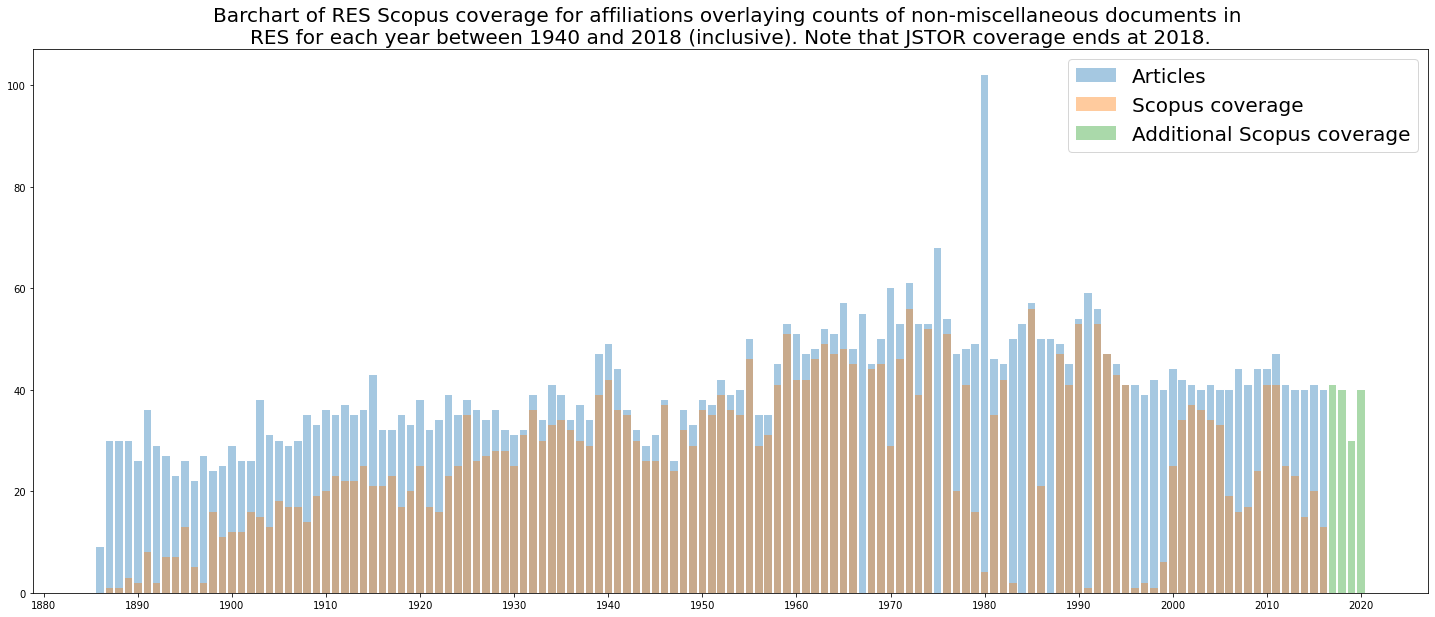

In [16]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['affiliations'].isnull()==False) & (scopus['year']>2016)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of RES Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nRES for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1880, 2030, 10))
plt.legend(prop={'size': 20})

In [18]:
sc_aff=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()
js_aff=Merged[(Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()

In [19]:
difference=pd.DataFrame(js_aff-sc_aff).reset_index()  #get difference
difference=pd.merge(difference, js_aff.reset_index(), on=['year', 'issue','volume'], how='right').sort_values(['year','issue','volume'])
difference['retrieval_req']=difference['0_x']/difference['0_y']
difference.rename(columns = {'0_x':'missing', '0_y':'total'}, inplace = True)
difference['retrieval_req'] = difference['retrieval_req'].fillna(1)

difference[difference['year']>=1940] # if missing is NaN that means the whole issue is missing.


,year,volume,issue,missing,total,retrieval_req
141,1940,55,1,1.0,11,0.090909
10,1940,54,2,3.0,16,0.187500
255,1940,54,3,1.0,10,0.100000
102,1940,54,4,2.0,12,0.166667
79,1941,56,1,3.0,13,0.230769
...,...,...,...,...,...,...
232,2015,130,4,6.0,10,0.600000
231,2016,131,1,NaN,10,1.000000
228,2016,131,2,3.0,10,0.300000
226,2016,131,3,4.0,10,0.400000


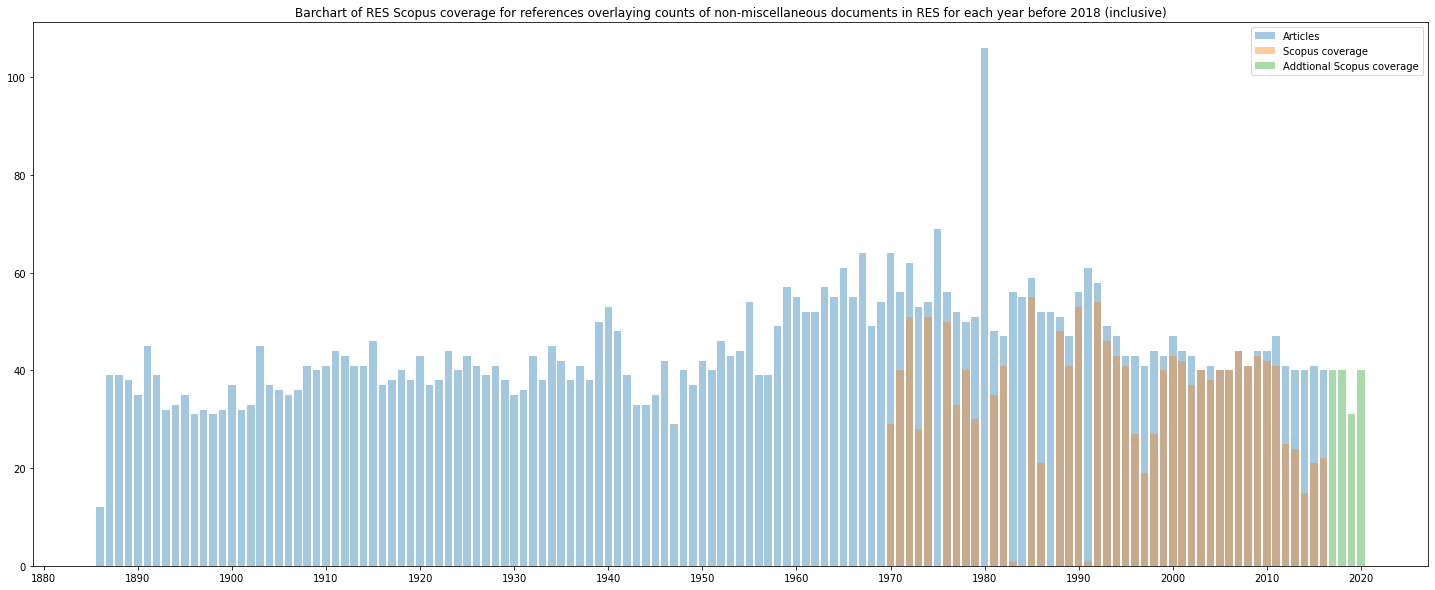

In [17]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2016)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of RES Scopus coverage for references overlaying counts of non-miscellaneous documents in RES for each year before 2018 (inclusive)')
plt.xticks(np.arange(1880, 2030, 10))
plt.legend()